In [1]:
import os
import numpy as np
import pandas as pd

import geopandas as gpd
import ee, eemont
import geemap
import geemap.colormaps as geecm

import matplotlib.pyplot as plt
import cmocean

# 1. Initialization GEE

In [2]:
ee.Authenticate()
ee.Initialize()

# 2. Load GEE datasets + parameters

In [3]:
dem_glo30 = ee.ImageCollection("COPERNICUS/DEM/GLO30")

In [4]:
fc_lia = ee.FeatureCollection('users/aguerou/ice_and_life/carto_h1b/lia_shp/glaciers_1850_final_mars_2025') # demander les références
geom_lia = ee.Geometry.convexHull(fc_lia.geometry())

In [5]:
# Time parameters
startYear = 1984
endYear = 2024

startMonth = 7
endMonth = 9

date_filter = ee.Filter.calendarRange(7, 9, 'month') \
    .And(ee.Filter.calendarRange(15, None, 'day_of_month')) \
    .And(ee.Filter.calendarRange(None, 15, 'day_of_month'))

#Cloud correction
cloudThresh = 0.4
cloudBuff = 1000
cloudCover = 50

#

SlopeThresh = 20 
AltitudeThresh = 1000


Scale and projection

In [6]:
scale = 30 #Landsat 30m
projection = "EPSG:4326" #GEE le plus stable avec ce SRC

# I. Functions

Mask terrain

In [7]:
def removeValley(image):
    return image.updateMask(valley_mask)

In [8]:
def get_slope(image):
    return ee.Terrain.slope(image)

Clouds

In [9]:
#V2 with comments : à conserver car filtre plus opti que le filtre interne du module
def addCloud(image):
    # Sélectionner le bande TIR et appliquer une échelle d'unité (unitScale)
    TIR = image.select('TIR').unitScale(240, 270).rename('sTIR')
    
    # Sélectionner le bande SWIR2
    SWIR2 = image.select('SWIR2').rename('sSWIR2')
    
    # Ajouter les bandes sTIR et sSWIR2
    temp = TIR.addBands(SWIR2)
    
    # Ajouter la bande de différence normalisée NDCI
    temp2 = temp.addBands(temp.normalizedDifference(['sTIR', 'sSWIR2']).rename('NDCI'))
    
    # Ajouter une bande NDCIt qui est le seuil des nuages
    temp3 = temp2.addBands(temp2.select('NDCI').lte(cloudThresh).rename('NDCIt'))
    
    # Calculer le masque avec la transformation de distance
    mask = temp3.select('NDCIt') \
                .fastDistanceTransform(50, 'pixels', 'squared_euclidean') \
                .sqrt() \
                .multiply(ee.Image.pixelArea().sqrt()) \
                .gt(cloudBuff)
    
    # Appliquer le masque à l'image 
    return image.updateMask(mask)

Index + scaling factors

In [10]:
#ref calcul des indices : https://doi.org/10.1016/j.rse.2021.112862 (notamment GBR et cloud filter)

def addGBR(image):
    gbr = image.expression(
        'NIR / SWIR1', 
        {
            'NIR': image.select('NIR'),  # Référence à la bande NIR
            'SWIR1': image.select('SWIR1')  # Référence à la bande SWIR1
        }
    )
    return image.addBands(gbr.rename('GBR'))

Clip geometry to LIA

In [11]:
def clip_to_lia(image,geom):
    return image.clip(geom)

Get Median

In [12]:
# Liste des années
years = ee.List.sequence(startYear, endYear)

# Fonction de traitement pour chaque année à mettre en haut
def process_year(year):
    # Filtrer la collection LXtemp pour l'année donnée
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)
    year_collection = LXtemp.filterDate(start_date, end_date)
    # Calculer la médiane pour chaque année (sur les 3 bandes)
    annual_median = year_collection.median() \
                         .addBands(ee.Image.constant(ee.Number(year)).toDouble().rename('year')) \
                         .set('year', year) \
                         .selfMask()
    
    return annual_median


# II. Terrain data / Timeseries Landsat

Terrain

In [13]:
dem = ee.ImageCollection(dem_glo30).filterBounds(fc_lia).select("DEM")
dem_mosaic = dem.mosaic().clip(fc_lia)
slope = dem.map(get_slope).mosaic().clip(fc_lia) \
#need to map on single image for slope function to work fine

slope_mask = slope.lt(SlopeThresh)
valley_mask = dem_mosaic.gt(AltitudeThresh)

Landsat

In [14]:
#ajouter les bandes correspondantes # virer Qa pixel
L5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") \
            .filter(ee.Filter.calendarRange(startMonth, endMonth,'month')) \
            .filterBounds(fc_lia) \
            .filterMetadata("CLOUD_COVER", "less_than", cloudCover) \
            .scaleAndOffset() \
            .map(lambda image: clip_to_lia(image,fc_lia)) \
            .spectralIndices(["NDWI","NDVI","NDSI","BITM"]) \
            .select(['SR_B1','SR_B2', 'SR_B3', 'SR_B4', 'SR_B5','SR_B7','ST_B6',"NDWI","NDVI","NDSI","BITM"], \
                    ['BLUE','GREEN', 'RED', 'NIR', 'SWIR1','SWIR2','TIR',"NDWI","NDVI","NDSI","BITM"])

L7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") \
            .filter(ee.Filter.calendarRange(startMonth, endMonth,'month')) \
            .filterBounds(fc_lia) \
            .filterMetadata('CLOUD_COVER', 'less_than', cloudCover) \
            .scaleAndOffset() \
            .map(lambda image: clip_to_lia(image,fc_lia)) \
            .spectralIndices(["NDWI","NDVI","NDSI","BITM"]) \
            .select(['SR_B1','SR_B2', 'SR_B3', 'SR_B4', 'SR_B5','SR_B7','ST_B6',"NDWI","NDVI","NDSI","BITM"],['BLUE','GREEN', 'RED', 'NIR', 'SWIR1','SWIR2','TIR',"NDWI","NDVI","NDSI","BITM"])

L8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
            .filter(ee.Filter.calendarRange(startMonth, endMonth,'month')) \
            .filterBounds(fc_lia) \
            .filterMetadata('CLOUD_COVER', 'less_than', cloudCover) \
            .scaleAndOffset() \
            .map(lambda image: clip_to_lia(image,fc_lia)) \
            .spectralIndices(["NDWI","NDVI","NDSI","BITM"]) \
            .select(['SR_B2','SR_B3', 'SR_B4', 'SR_B5', 'SR_B6','SR_B7','ST_B10',"NDWI","NDVI","NDSI","BITM"], \
                    ['BLUE','GREEN', 'RED', 'NIR', 'SWIR1','SWIR2','TIR',"NDWI","NDVI","NDSI","BITM"])

In [15]:
L5_filtered=L5.filter(ee.Filter.dayOfYear(196, 258))
L7_filtered=L7.filter(ee.Filter.dayOfYear(196, 258))
L8_filtered=L8.filter(ee.Filter.dayOfYear(196, 258))

In [16]:
LXtemp = L5_filtered.merge(L7_filtered).merge(L8_filtered) \
                .map(addCloud) \
                .map(addGBR)  

In [38]:
LXtemp

TypeError: 'module' object is not callable

In [37]:
# Exporter une image pour estimer sa taille réelle

geemap.ee_export_image_to_drive({
    'image': image_example,
    'description': 'example_image_export',
    'scale': 30,
    'region': image_example.geometry(),
    'fileFormat': 'GeoTIFF'
})

TypeError: 'module' object is not callable

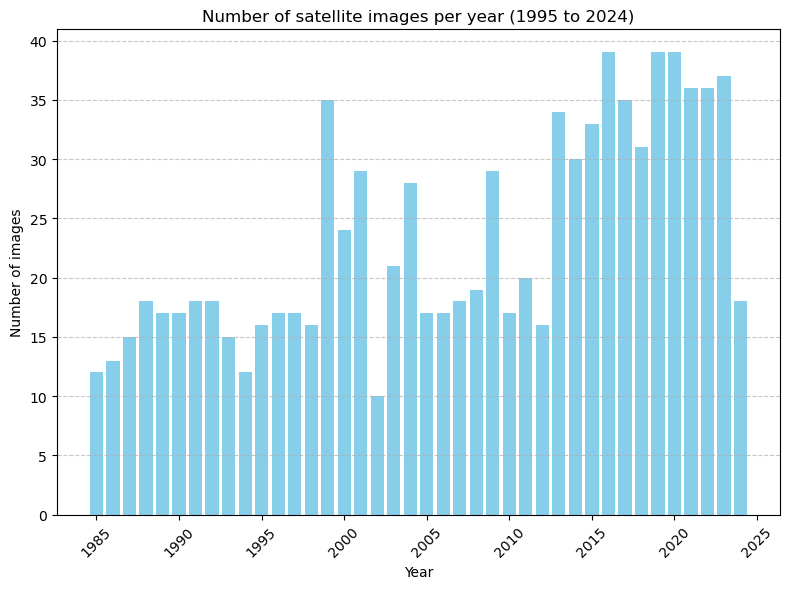

In [18]:
# Fonction pour ajouter l'année comme propriété
def add_year(image):
    year = image.date().get('year')
    return image.set('year', year)

with_year = LXtemp.map(add_year)

# Utiliser reduceColumns pour obtenir un histogramme de fréquence sur la propriété 'year'
count_by_year = with_year.reduceColumns(
    reducer=ee.Reducer.frequencyHistogram(),
    selectors=['year']
).get('histogram')

# Obtenir le résultat 
count_by_year_dict = count_by_year.getInfo()
xticks = list(range(1985, 2026, 5))
start_year = 1985
end_year = 2024

years_all = [int(y) for y in count_by_year_dict.keys()]
years_filtered = [y for y in years_all if start_year <= y <= end_year]
years_filtered.sort()

counts_filtered = [count_by_year_dict[str(y)] if str(y) in count_by_year_dict else 0 for y in years_filtered]

plt.figure(figsize=(8,6))
plt.bar(years_filtered, counts_filtered, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of images')
plt.title('Number of satellite images per year (1995 to 2024)')
plt.xticks(xticks, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
total_images = sum(count_by_year_dict.values())
print("Nombre total d'images :", total_images)

Nombre total d'images : 940


In [17]:
annualCollection = ee.ImageCollection(years.map(process_year))

In [18]:
annualCollection

C:\Users\ronir\anaconda3\envs\gee\Lib\site-packages\IPython\core\formatters.py:406: UserWarning: Getting info failed with: 'User memory limit exceeded.'. Falling back to string repr.
  return method()


In [31]:
# Loop through each image in the annualCollection and export it
for i in range(annualCollection.size().getInfo()):
    image = ee.Image(annualCollection.toList(annualCollection.size()).get(i))
    
    
    # Export the image
    geemap.ee_export_image_to_asset(
        image=image,
        description=None,
        assetId=f'projects/ee-roniritzganem/assets/stage_carrtel_2025/landsat_annual_median_index/Landsat_{1983+i}',
        region=geom_lia,
        scale=scale,
        maxPixels=1e13,
        crs=projection
    )